### Objective

In this notebook, we will use AutoML library to address the NSL-KDD dataset

### 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#### 1.1 Load dataset

In [2]:
# import train data
train = pd.read_csv('dataset/train_AutoML.csv')
train.rename(columns={'attack_category': 'attack'}, inplace=True)

# import test data
test = pd.read_csv('dataset/test_AutoML.csv')
test.rename(columns={'attack_category': 'attack'}, inplace=True)

#### 1.2 Feature category

In [3]:
feature_names = defaultdict(list)
with open('dataset/feature_types.txt', 'r') as f:
    for line in f.readlines():
        feature, category = line.strip().strip('.').split(': ')
        feature_names[category].append(feature)

# continuous features
continuous_features = feature_names['continuous']
continuous_features.remove('num_outbound_cmds')

# binary features
binary_features = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

# nominal features
nominal_features = list(set(feature_names['discrete'])-set(binary_features))

#### 1.3 Ordinal encoding

In [4]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
train[nominal_features] = enc.fit_transform(train[nominal_features])
test[nominal_features] = enc.transform(test[nominal_features])

# Separate feature/label
X_train, y_train = train.iloc[:, :-1].to_numpy(), train.iloc[:, -1].to_numpy()
X_test, y_test = test.iloc[:, :-1].to_numpy(), test.iloc[:, -1].to_numpy()

### 2. ML modeling

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    accuracy_score, 
    roc_auc_score,
    roc_curve,
    matthews_corrcoef
)


def metrics_display(y_test, y_pred):

    # Obtain confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Output classification metrics
    tn, fp, fn, tp = cm.ravel()
    
    # print(f'ROC_AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Precision: {precision_score(y_test, y_pred)*100:.2f}%')
    print(f'Detection rate: {recall_score(y_test, y_pred)*100:.2f}%')
    print(f'False alarm rate: {fp / (tn+fp)*100}%')
    print(f'MCC: {matthews_corrcoef(y_test, y_pred):.2f}')
    
    # Display confusion matrix
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='.5g', colorbar=False)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

#### 2.1 Default XGBoost model

Accuracy: 86.13%
Precision: 96.87%
Detection rate: 78.16%
False alarm rate: 3.3364226135310475%
MCC: 0.74
CPU times: total: 35 s
Wall time: 3.26 s


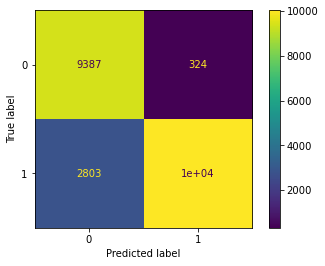

In [42]:
%%time
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(eval_metric='auc', 
                            max_depth=4,
                            learning_rate=0.3,
                            reg_lambda=50,
                            gamma=5,
                            subsample=1,
                            colsample_bytree=1,
                            use_label_encoder=False,
                            scale_pos_weight=50,
                            n_jobs=-1,
                            seed=42)

clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test)
metrics_display(y_test, y_pred)

#### 2.2 AutoML with FLAML

In [62]:
from flaml import AutoML
automl = AutoML()
automl.fit(X_train, y_train, task="classification", time_budget=20, estimator_list=['lgbm'],
          log_file_name='automl.log', log_type='best')

[flaml.automl: 09-05 17:39:23] {2373} INFO - task = classification
[flaml.automl: 09-05 17:39:23] {2375} INFO - Data split method: stratified
[flaml.automl: 09-05 17:39:23] {2379} INFO - Evaluation method: holdout
[flaml.automl: 09-05 17:39:23] {2448} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 09-05 17:39:23] {2586} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 09-05 17:39:23] {2878} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-05 17:39:23] {3008} INFO - Estimated sufficient time budget=2831s. Estimated necessary time budget=3s.
[flaml.automl: 09-05 17:39:23] {3055} INFO -  at 0.2s,	estimator lgbm's best error=0.0252,	best estimator lgbm's best error=0.0252
[flaml.automl: 09-05 17:39:23] {2878} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-05 17:39:23] {3055} INFO -  at 0.3s,	estimator lgbm's best error=0.0183,	best estimator lgbm's best error=0.0183
[flaml.automl: 09-05 17:39:23] {2878} INFO - iteration 2, current learner lg

[flaml.automl: 09-05 17:39:35] {2878} INFO - iteration 37, current learner lgbm
[flaml.automl: 09-05 17:39:36] {3055} INFO -  at 13.6s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 09-05 17:39:36] {2878} INFO - iteration 38, current learner lgbm
[flaml.automl: 09-05 17:39:37] {3055} INFO -  at 14.0s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 09-05 17:39:37] {2878} INFO - iteration 39, current learner lgbm
[flaml.automl: 09-05 17:39:38] {3055} INFO -  at 15.1s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 09-05 17:39:38] {2878} INFO - iteration 40, current learner lgbm
[flaml.automl: 09-05 17:39:38] {3055} INFO -  at 15.3s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 09-05 17:39:38] {2878} INFO - iteration 41, current learner lgbm
[flaml.automl: 09-05 17:39:38] {3055} INFO -  at 15.6s,	estimator lgbm's

Accuracy: 76.84%
Precision: 96.68%
Detection rate: 61.42%
False alarm rate: 2.790649778601586%
MCC: 0.60


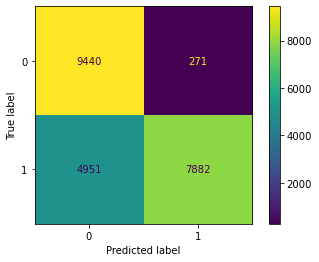

In [63]:
y_pred = automl.predict(X_test)
metrics_display(y_test, y_pred)

#### 2.3 Develop AutoML API

In [89]:
opt = {}

In [98]:
from langchain.tools import tool

@tool("AutoML-LightGBM")
def auto_machine_learning(time_budget: float, metric: str, custom_hp: dict) -> str:
    """Hyperparameter tuning with FLAML library. The tunable hyperparameters for LightGBM are: 
    n_estimators, num_leaves, min_child_samples, learning_rate, 
    log_max_bin (logarithm of (max_bin + 1) with base 2), 
    colsample_bytree, reg_alpha, reg_lambda.
    
    Args:
    ------
    time_budget: A float number of the time budget in seconds.
    metric: The optimization metric. 
            Built-in metric:
                'accuracy': 1 - accuracy as the corresponding metric to minimize.
                'roc_auc': minimize 1 - roc_auc_score. 
                'f1': minimize 1 - f1_score.
            User-defined function:
                A customized metric function that requires the following (input) signature, and returns the input 
                config’s value in terms of the metric you want to minimize, and a dictionary of auxiliary information 
                at your choice:
                
                    def custom_metric(
                        X_val, y_val, estimator, labels,
                        X_train, y_train, weight_val=None, weight_train=None,
                        config=None, groups_val=None, groups_train=None,
                    ):
                        return metric_to_minimize, metrics_to_log
                        
                For example:
                
                    def custom_metric(
                        X_val, y_val, estimator, labels,
                        X_train, y_train, weight_val=None, weight_train=None,
                        *args,
                    ):
                        from sklearn.metrics import log_loss
                        import time

                        start = time.time()
                        y_pred = estimator.predict_proba(X_val)
                        pred_time = (time.time() - start) / len(X_val)
                        val_loss = log_loss(y_val, y_pred, labels=labels, sample_weight=weight_val)
                        y_pred = estimator.predict_proba(X_train)
                        train_loss = log_loss(y_train, y_pred, labels=labels, sample_weight=weight_train)
                        alpha = 0.5
                        return val_loss * (1 + alpha) - alpha * train_loss, {
                            "val_loss": val_loss,
                            "train_loss": train_loss,
                            "pred_time": pred_time,
                        }
    custom_hp: The custom search space specified by user.It is a nested dict with keys being hyperparameter names, 
               and values are dicts of info ("domain" and "init_value") about the search space associated with the 
               hyperparameter. For example:
               
               custom_hp = {
                         "learning_rate": {
                             "domain": tune.loguniform(lower=0.01, upper=20.0),
                             "init_value": 1
                         }
               }
               
               See the example below for the commonly used types of domains.
               
                # Sample a float uniformly between -5.0 and -1.0
                tune.uniform(-5, -1),

                # Sample a float uniformly between 3.2 and 5.4,
                # rounding to increments of 0.2
                tune.quniform(3.2, 5.4, 0.2),

                # Sample a float uniformly between 0.0001 and 0.01, while
                # sampling in log space
                tune.loguniform(1e-4, 1e-2),

                # Sample a float uniformly between 0.0001 and 0.1, while
                # sampling in log space and rounding to increments of 0.00005
                tune.qloguniform(1e-4, 1e-1, 5e-5),

                # Sample a random float from a normal distribution with
                # mean=10 and sd=2
                tune.randn(10, 2),

                # Sample a random float from a normal distribution with
                # mean=10 and sd=2, rounding to increments of 0.2
                tune.qrandn(10, 2, 0.2),

                # Sample a integer uniformly between -9 (inclusive) and 15 (exclusive)
                tune.randint(-9, 15),

                # Sample a random uniformly between -21 (inclusive) and 12 (inclusive (!))
                # rounding to increments of 3 (includes 12)
                tune.qrandint(-21, 12, 3),

                # Sample a integer uniformly between 1 (inclusive) and 10 (exclusive),
                # while sampling in log space
                tune.lograndint(1, 10),

                # Sample a integer uniformly between 2 (inclusive) and 10 (inclusive (!)),
                # while sampling in log space and rounding to increments of 2
                tune.qlograndint(2, 10, 2),

                # Sample an option uniformly from the specified choices
                tune.choice(["a", "b", "c"])  
                
                
    Outputs:
    --------
    record: log of tuning process, including the tuning history and the currently found 
            best configurations.
    """
    
    # AutoML object
    automl = AutoML()
    
    # Tuning config
    config = {
        'task': 'classification',
        'metric': metric,
        'time_budget': time_budget,
        'estimator_list': ['lgbm'],
        'custom_hp': {'lgbm': custom_hp},
        'log_file_name': 'automl.log',
    }
    
    # Fitting
    automl.fit(X_train, y_train, **config)
    opt['model'] = automl
    
    # Tuning logs
    with open("automl.log", "r") as txt_file:
        log = txt_file.readlines()
    record = {
        'log': log,
        'best config': automl.best_config
    }
    
    return record

In [99]:
from flaml import tune
time_budget = 10
metric = 'accuracy'
    
custom_hp = {
         "learning_rate": {
             "domain": tune.loguniform(lower=0.01, upper=1),
             "init_value": 0.1
         }
}

In [100]:
record = auto_machine_learning(time_budget, metric, custom_hp)

[flaml.automl: 09-05 22:50:57] {2373} INFO - task = classification
[flaml.automl: 09-05 22:50:57] {2375} INFO - Data split method: stratified
[flaml.automl: 09-05 22:50:57] {2379} INFO - Evaluation method: holdout
[flaml.automl: 09-05 22:50:57] {2448} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 09-05 22:50:57] {2586} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 09-05 22:50:57] {2878} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-05 22:50:58] {3008} INFO - Estimated sufficient time budget=4650s. Estimated necessary time budget=5s.
[flaml.automl: 09-05 22:50:58] {3055} INFO -  at 0.3s,	estimator lgbm's best error=0.0518,	best estimator lgbm's best error=0.0518
[flaml.automl: 09-05 22:50:58] {2878} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-05 22:50:58] {3055} INFO -  at 0.3s,	estimator lgbm's best error=0.0518,	best estimator lgbm's best error=0.0518
[flaml.automl: 09-05 22:50:58] {2878} INFO - iteration 2, current learner l

#### Agent testing

In [111]:
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
import os

# llm = ChatOpenAI(temperature=0)
llm = AzureChatOpenAI(openai_api_base="https://abb-chcrc.openai.azure.com/",
            openai_api_version="2023-03-15-preview",
            openai_api_key=os.environ["OPENAI_API_KEY_AZURE"],
            openai_api_type="azure",
            deployment_name="gpt-35-turbo-0301")

In [112]:
from langchain.agents import tool

@tool
def get_word_length(word: str) -> int:
    """Returns the length of a word."""
    return len(word)

tools = [get_word_length]

In [113]:
from langchain.schema import SystemMessage
from langchain.agents import OpenAIFunctionsAgent
system_message = SystemMessage(content="You are very powerful assistant, but bad at calculating lengths of words.")
prompt = OpenAIFunctionsAgent.create_prompt(system_message=system_message)

In [114]:
agent = OpenAIFunctionsAgent(llm=llm, tools=tools, prompt=prompt)

In [115]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [116]:
agent_executor.run("how many letters in the word educa?")



> Entering new  chain...


InvalidRequestError: Unrecognized request argument supplied: functions